Trades: 306, Wins: 133, Losses: 173, Total PnL (price units): 23073.78, Avg R: 0.25
       box_date          entry_time   side  entry_price         sl        tp  \
0    2024-11-19 2024-11-19 14:00:00  short     2628.719  2634.0415  2618.074   
1    2024-11-21 2024-11-21 14:00:00  short     2662.897  2667.3565  2653.978   
2    2024-11-21 2024-11-21 17:00:00   long     2671.816  2667.3565  2680.735   
3    2024-11-22 2024-11-22 14:00:00  short     2696.996  2701.0070  2688.974   
4    2024-11-22 2024-11-22 15:00:00   long     2705.018  2701.0070  2713.040   
..          ...                 ...    ...          ...        ...       ...   
301  2025-11-19 2025-11-19 14:00:00   long     4120.010  4116.0970  4127.836   
302  2025-11-19 2025-11-19 14:00:00  short     4112.184  4116.0970  4104.358   
303  2025-11-20 2025-11-20 14:00:00   long     4082.084  4071.0840  4104.084   
304  2025-11-20 2025-11-20 16:00:00  short     4060.084  4071.0840  4038.084   
305  2025-11-24 2025-11-24 14:00:00 

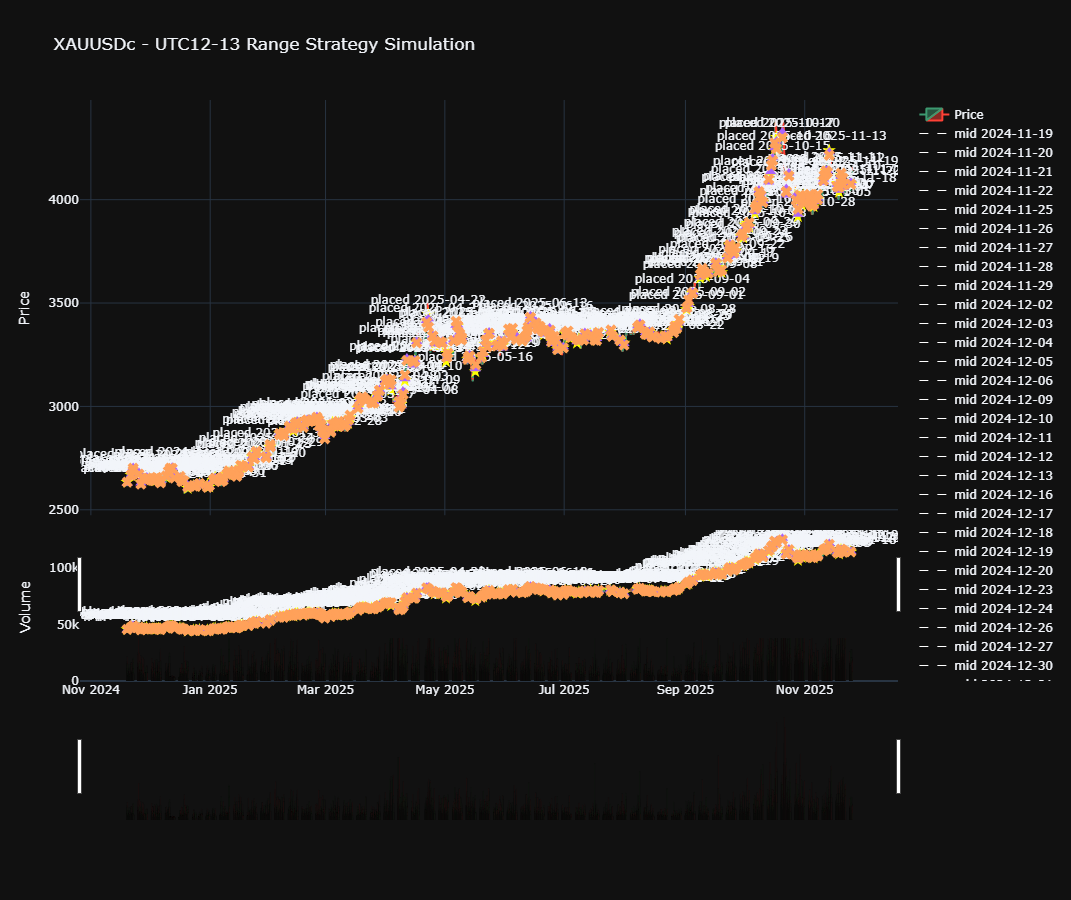

In [9]:
# -----------------------------
# STRATEGY: UTC 12→13 RANGE + REVISIT -> PLACE BOTH STOPS (Buy @High, Sell @Low)
# Backtest simulation (no live order placement)
# -----------------------------

import MetaTrader5 as mt
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import timedelta

# -----------------------------
# 0. CONFIG
# -----------------------------
symbol = "XAUUSDc"           # change to your broker symbol
timeframe = mt.TIMEFRAME_H1  # M30 data
num_candles = 6000           # load enough history to get many days
lookback = 500                 # keep existing swing logic (unused for strategy here)
risk_multiplier = 2.0        # TP = 2R

# -----------------------------
# 1. CONNECT & FETCH
# -----------------------------
if not mt.initialize():
    raise RuntimeError("MT5 initialization failed")

rates = mt.copy_rates_from_pos(symbol, timeframe, 0, num_candles)
df = pd.DataFrame(rates)
df['time'] = pd.to_datetime(df['time'], unit='s')
df.set_index('time', inplace=True)
df.rename(columns={'open':'Open','high':'High','low':'Low','close':'Close','tick_volume':'Volume'}, inplace=True)

# -----------------------------
# 2. CALC DELTA (optional)
# -----------------------------
df['Delta'] = df.apply(lambda r: r['Volume'] if r['Close']>r['Open'] else (-r['Volume'] if r['Close']<r['Open'] else 0), axis=1)

# -----------------------------
# 3. BUILD DAILY UTC 12->13 BOXES
# -----------------------------
df_utc = df.copy()
df_utc.index = df_utc.index.tz_localize('UTC')
df_utc['Date'] = df_utc.index.date

session_boxes = []
for day, day_df in df_utc.groupby('Date'):
    session_df = day_df[(day_df.index.hour == 12)]  # 12:00 - 12:59 UTC
    if len(session_df) == 0:
        continue
    session_high = session_df['High'].max()
    session_low  = session_df['Low'].min()
    session_start = session_df.index[0]
    session_end   = session_df.index[-1]
    mid = (session_high + session_low) / 2.0
    session_boxes.append({
        'date': day,
        'start': session_start,
        'end': session_end,
        'high': session_high,
        'low': session_low,
        'mid': mid
    })

# -----------------------------
# 4. STRATEGY SIMULATION WITH 1% RISK MANAGEMENT + 20% COMMISSION
# -----------------------------
trades = []  # list of dicts {entry_time, side, entry_price, sl, tp, exit_time, exit_price, pnl, r, position_size}
verbose = False

equity = 2000  # starting capital
risk_per_trade_pct = 0.05  # 1% risk per trade
commission_pct = 0.20       # 20% commission on profit/loss

for box in session_boxes:
    session_end_naive = box['end'].tz_convert(None) if hasattr(box['end'], 'tzinfo') else box['end']
    try:
        start_loc = df.index.get_loc(session_end_naive)
    except KeyError:
        future_idx = df.index.searchsorted(session_end_naive)
        start_loc = future_idx

    # Monitor candles **only for the same day**
    monitor_slice = df.iloc[start_loc+1:]
    monitor_slice = monitor_slice[monitor_slice.index.date == box['date']]
    if monitor_slice.empty:
        continue

    mid = box['mid']
    box_high = box['high']
    box_low = box['low']

    placed_pending = False
    my_pending = []

    for idx, row in monitor_slice.iterrows():
        # Check for mid revisit to place pending orders
        if not placed_pending:
            if (row['Low'] <= mid <= row['High']):
                placed_pending = True

                # Define buystop at box_high
                buy_entry = box_high
                buy_sl = mid
                buy_r = abs(buy_entry - buy_sl)
                buy_tp = buy_entry + risk_multiplier * buy_r
                buy_position_size = (equity * risk_per_trade_pct) / buy_r  # position size to risk 1%

                # Define sellstop at box_low
                sell_entry = box_low
                sell_sl = mid
                sell_r = abs(sell_entry - sell_sl)
                sell_tp = sell_entry - risk_multiplier * sell_r
                sell_position_size = (equity * risk_per_trade_pct) / sell_r

                my_pending = [
                    {'side':'buystop', 'entry':buy_entry, 'sl':buy_sl, 'tp':buy_tp, 'position_size':buy_position_size,
                     'placed_at': idx, 'activated': False},
                    {'side':'sellstop','entry':sell_entry,'sl':sell_sl,'tp':sell_tp,'position_size':sell_position_size,
                     'placed_at': idx,'activated': False}
                ]
                if verbose:
                    print(f"[{box['date']}] Mid revisit at {idx} -> placed pending buy @ {buy_entry} and sell @ {sell_entry}")
                continue
            else:
                continue

        # Check executions for pending orders
        for po in my_pending:
            if po['activated']:
                continue
            if po['side'] == 'buystop':
                if row['High'] >= po['entry']:
                    entry_time = idx
                    entry_price = po['entry']
                    sl = po['sl']
                    tp = po['tp']
                    pos_idx = monitor_slice.index.get_loc(idx)
                    exit_price = None
                    exit_time = None
                    pnl = None
                    for j in range(pos_idx, len(monitor_slice)):
                        r2 = monitor_slice.iloc[j]
                        if r2['High'] >= tp:
                            exit_price = tp
                            exit_time = monitor_slice.index[j]
                            pnl = (exit_price - entry_price) * po['position_size']
                            break
                        if r2['Low'] <= sl:
                            exit_price = sl
                            exit_time = monitor_slice.index[j]
                            pnl = (exit_price - entry_price) * po['position_size']
                            break
                    if exit_price is None:
                        exit_time = monitor_slice.index[-1]
                        exit_price = monitor_slice.iloc[-1]['Close']
                        pnl = (exit_price - entry_price) * po['position_size']

                    # Apply commission
                    pnl *= (1 - commission_pct)

                    trades.append({
                        'box_date': box['date'],
                        'entry_time': entry_time,
                        'side': 'long',
                        'entry_price': entry_price,
                        'sl': sl,
                        'tp': tp,
                        'exit_time': exit_time,
                        'exit_price': exit_price,
                        'pnl': pnl,
                        'r': (exit_price - entry_price) / (entry_price - sl) if (entry_price - sl) != 0 else np.nan,
                        'position_size': po['position_size'],
                        'triggered_by': 'buystop'
                    })
                    po['activated'] = True
                    equity += pnl  # update equity after trade

            elif po['side'] == 'sellstop':
                if row['Low'] <= po['entry']:
                    entry_time = idx
                    entry_price = po['entry']
                    sl = po['sl']
                    tp = po['tp']
                    pos_idx = monitor_slice.index.get_loc(idx)
                    exit_price = None
                    exit_time = None
                    pnl = None
                    for j in range(pos_idx, len(monitor_slice)):
                        r2 = monitor_slice.iloc[j]
                        if r2['Low'] <= tp:
                            exit_price = tp
                            exit_time = monitor_slice.index[j]
                            pnl = (entry_price - exit_price) * po['position_size']
                            break
                        if r2['High'] >= sl:
                            exit_price = sl
                            exit_time = monitor_slice.index[j]
                            pnl = (entry_price - exit_price) * po['position_size']
                            break
                    if exit_price is None:
                        exit_time = monitor_slice.index[-1]
                        exit_price = monitor_slice.iloc[-1]['Close']
                        pnl = (entry_price - exit_price) * po['position_size']

                    # Apply commission
                    pnl *= (1 - commission_pct)

                    trades.append({
                        'box_date': box['date'],
                        'entry_time': entry_time,
                        'side': 'short',
                        'entry_price': entry_price,
                        'sl': sl,
                        'tp': tp,
                        'exit_time': exit_time,
                        'exit_price': exit_price,
                        'pnl': pnl,
                        'r': (entry_price - exit_price) / (sl - entry_price) if (sl - entry_price) != 0 else np.nan,
                        'position_size': po['position_size'],
                        'triggered_by': 'sellstop'
                    })
                    po['activated'] = True
                    equity += pnl  # update equity after trade

        if all(po['activated'] for po in my_pending) and len(my_pending) > 0:
            break

    # Reset per-box pending orders to avoid carryover
    my_pending = []
    placed_pending = False


# -----------------------------
# 5. REPORT RESULTS
# -----------------------------
trades_df = pd.DataFrame(trades)
if trades_df.empty:
    print("No trades executed in this backtest (no mid revisits or triggers).")
else:
    total_pnl = trades_df['pnl'].sum()
    wins = trades_df[trades_df['pnl'] > 0].shape[0]
    losses = trades_df[trades_df['pnl'] <= 0].shape[0]
    avg_r = trades_df['r'].mean()
    print(f"Trades: {len(trades_df)}, Wins: {wins}, Losses: {losses}, Total PnL (price units): {total_pnl:.2f}, Avg R: {avg_r:.2f}")

print(pd.DataFrame(trades))

# -----------------------------
# 6. PLOT (candles + boxes + pending/entries/exits)
# -----------------------------
fig = make_subplots(rows=2, cols=1, shared_xaxes=True, row_heights=[0.7,0.25], vertical_spacing=0.03)

fig.add_trace(go.Candlestick(
    x=df.index, open=df['Open'], high=df['High'], low=df['Low'], close=df['Close'], name='Price'
), row=1, col=1)

for b in session_boxes:
    fig.add_shape(
        type='rect',
        x0=b['start'].tz_convert(None) if hasattr(b['start'],'tzinfo') else b['start'],
        x1=b['end'].tz_convert(None) if hasattr(b['end'],'tzinfo') else b['end'],
        y0=b['low'], y1=b['high'],
        line=dict(color='cyan', width=1),
        fillcolor='rgba(0,255,255,0.10)',
        layer='below'
    )
    fig.add_trace(go.Scatter(
        x=[b['start'].tz_convert(None) if hasattr(b['start'],'tzinfo') else b['start'],
           b['end'].tz_convert(None) if hasattr(b['end'],'tzinfo') else b['end']],
        y=[b['mid'], b['mid']],
        mode='lines',
        line=dict(color='white', width=1, dash='dash'),
        name=f"mid {b['date']}"
    ), row=1, col=1)

for box in session_boxes:
    session_end_naive = box['end'].tz_convert(None) if hasattr(box['end'],'tzinfo') else box['end']
    future_slice = df.loc[session_end_naive + timedelta(minutes=1):]
    future_slice = future_slice[future_slice.index.date == box['date']]
    revisit_index = None
    for idx, r in future_slice.iterrows():
        if r['Low'] <= box['mid'] <= r['High']:
            revisit_index = idx
            break
    if revisit_index is not None:
        fig.add_trace(go.Scatter(
            x=[revisit_index],
            y=[box['mid']],
            mode='markers+text',
            marker=dict(symbol='star', size=10, color='yellow'),
            text=[f"placed {box['date']}"],
            textposition='top center',
            showlegend=False
        ), row=1, col=1)

if not trades_df.empty:
    fig.add_trace(go.Scatter(
        x=trades_df['entry_time'],
        y=trades_df['entry_price'],
        mode='markers',
        marker=dict(size=10, symbol='triangle-up'),
        name='Entry'
    ), row=1, col=1)
    fig.add_trace(go.Scatter(
        x=trades_df['exit_time'],
        y=trades_df['exit_price'],
        mode='markers',
        marker=dict(size=10, symbol='x'),
        name='Exit'
    ), row=1, col=1)

colors = ['green' if d>0 else ('red' if d<0 else 'gray') for d in df['Delta']]
fig.add_trace(go.Bar(x=df.index, y=df['Volume'], marker_color=colors, name='Volume'), row=2, col=1)

fig.update_layout(template='plotly_dark', height=900, title=f"{symbol} - UTC12-13 Range Strategy Simulation")
fig.update_yaxes(title_text='Price', row=1, col=1)
fig.update_yaxes(title_text='Volume', row=2, col=1)
fig.update_xaxes(rangeslider_visible=True)

#fig.show()

# -----------------------------
# END
# -----------------------------


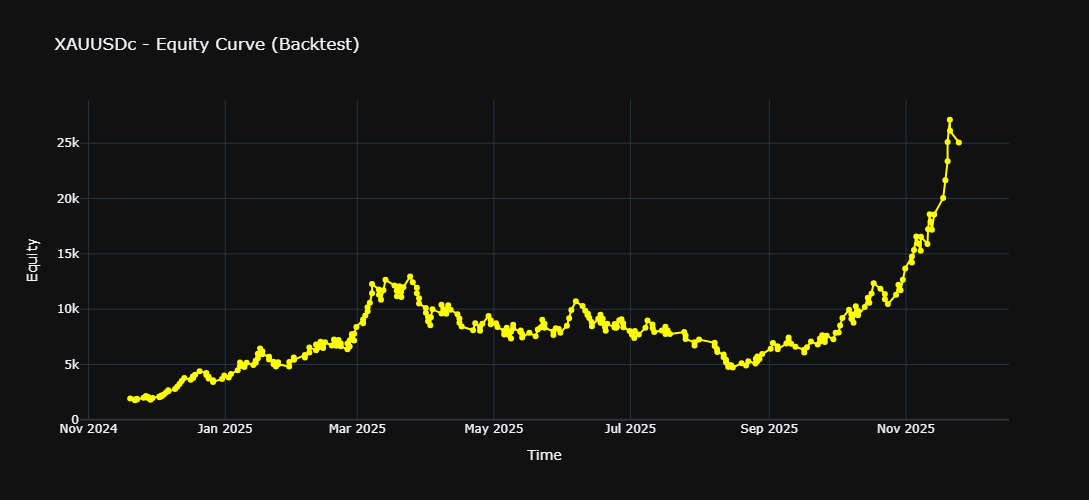

In [10]:
# -----------------------------
# 7. PLOT EQUITY CURVE
# -----------------------------
if trades_df.empty:
    print("No trades executed. Equity curve cannot be plotted.")
else:
    # Create equity curve
    trades_df = pd.DataFrame(trades)
    trades_df.sort_values('exit_time', inplace=True)
    equity_curve = []
    current_equity = 2000  # starting capital
    for idx, trade in trades_df.iterrows():
        current_equity += trade['pnl']
        equity_curve.append({'time': trade['exit_time'], 'equity': current_equity})

    equity_df = pd.DataFrame(equity_curve)
    equity_df.set_index('time', inplace=True)

    # Plot equity curve
    fig_eq = go.Figure()
    fig_eq.add_trace(go.Scatter(
        x=equity_df.index,
        y=equity_df['equity'],
        mode='lines+markers',
        line=dict(color='yellow', width=2),
        name='Equity Curve'
    ))
    fig_eq.update_layout(
        template='plotly_dark',
        title=f"{symbol} - Equity Curve (Backtest)",
        xaxis_title='Time',
        yaxis_title='Equity',
        height=500
    )
    fig_eq.show()


Trades: 303, Wins: 130, Losses: 173, Total PnL (price units): 16532.66, Avg R: 0.23
       box_date          entry_time   side  entry_price         sl        tp  \
0    2024-11-19 2024-11-19 14:00:00  short     2628.519  2634.0415  2617.474   
1    2024-11-21 2024-11-21 14:00:00  short     2662.697  2667.3565  2653.378   
2    2024-11-21 2024-11-21 17:00:00   long     2672.016  2667.3565  2681.335   
3    2024-11-22 2024-11-22 14:00:00  short     2696.796  2701.0070  2688.374   
4    2024-11-22 2024-11-22 16:00:00   long     2705.218  2701.0070  2713.640   
..          ...                 ...    ...          ...        ...       ...   
298  2025-11-19 2025-11-19 14:00:00   long     4120.210  4116.0970  4128.436   
299  2025-11-19 2025-11-19 14:00:00  short     4111.984  4116.0970  4103.758   
300  2025-11-20 2025-11-20 14:00:00   long     4082.284  4071.0840  4104.684   
301  2025-11-20 2025-11-20 16:00:00  short     4059.884  4071.0840  4037.484   
302  2025-11-24 2025-11-24 14:00:00 

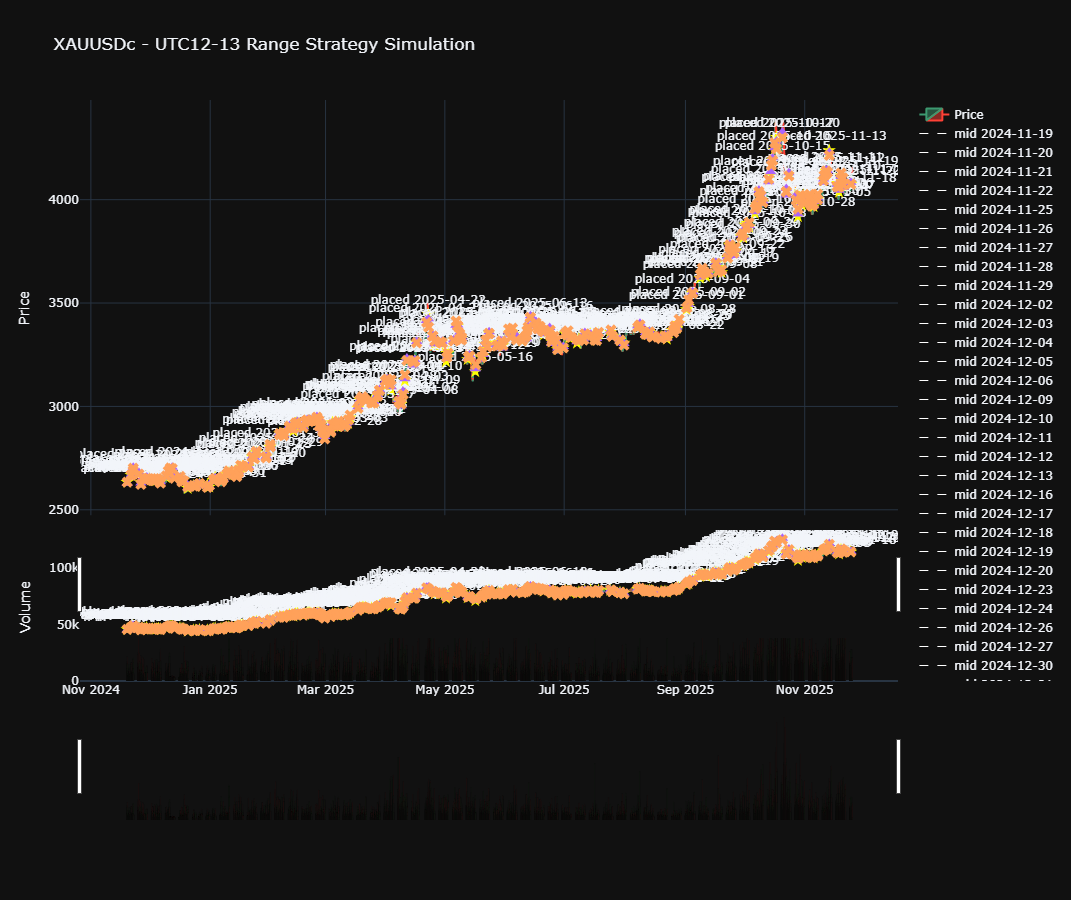

In [12]:
# -----------------------------
# STRATEGY: UTC 12→13 RANGE + REVISIT -> PLACE BOTH STOPS (Buy @High, Sell @Low)
# Backtest simulation (no live order placement)
# -----------------------------

import MetaTrader5 as mt
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import timedelta

# -----------------------------
# 0. CONFIG
# -----------------------------
symbol = "XAUUSDc"           # change to your broker symbol
timeframe = mt.TIMEFRAME_H1  # M30 data
num_candles = 6000           # load enough history to get many days
lookback = 500                 # keep existing swing logic (unused for strategy here)
risk_multiplier = 2.0        # TP = 2R

# -----------------------------
# 1. CONNECT & FETCH
# -----------------------------
if not mt.initialize():
    raise RuntimeError("MT5 initialization failed")

rates = mt.copy_rates_from_pos(symbol, timeframe, 0, num_candles)
df = pd.DataFrame(rates)
df['time'] = pd.to_datetime(df['time'], unit='s')
df.set_index('time', inplace=True)
df.rename(columns={'open':'Open','high':'High','low':'Low','close':'Close','tick_volume':'Volume'}, inplace=True)

# -----------------------------
# 2. CALC DELTA (optional)
# -----------------------------
df['Delta'] = df.apply(lambda r: r['Volume'] if r['Close']>r['Open'] else (-r['Volume'] if r['Close']<r['Open'] else 0), axis=1)

# -----------------------------
# 3. BUILD DAILY UTC 12->13 BOXES
# -----------------------------
df_utc = df.copy()
df_utc.index = df_utc.index.tz_localize('UTC')
df_utc['Date'] = df_utc.index.date

session_boxes = []
for day, day_df in df_utc.groupby('Date'):
    session_df = day_df[(day_df.index.hour == 12)]  # 12:00 - 12:59 UTC
    if len(session_df) == 0:
        continue
    session_high = session_df['High'].max()
    session_low  = session_df['Low'].min()
    session_start = session_df.index[0]
    session_end   = session_df.index[-1]
    mid = (session_high + session_low) / 2.0
    session_boxes.append({
        'date': day,
        'start': session_start,
        'end': session_end,
        'high': session_high,
        'low': session_low,
        'mid': mid
    })

# -----------------------------
# 4. STRATEGY SIMULATION WITH 1% RISK, 20% COMMISSION + SPREAD
# -----------------------------
trades = []  # list of dicts {entry_time, side, entry_price, sl, tp, exit_time, exit_price, pnl, r, position_size}
verbose = False

equity = 2000  # starting capital
risk_per_trade_pct = 0.05  # 5% risk per trade
commission_pct = 0.20       # 20% commission on profit/loss
spread = 0.2                # price units

for box in session_boxes:
    session_end_naive = box['end'].tz_convert(None) if hasattr(box['end'], 'tzinfo') else box['end']
    try:
        start_loc = df.index.get_loc(session_end_naive)
    except KeyError:
        future_idx = df.index.searchsorted(session_end_naive)
        start_loc = future_idx

    # Monitor candles **only for the same day**
    monitor_slice = df.iloc[start_loc+1:]
    monitor_slice = monitor_slice[monitor_slice.index.date == box['date']]
    if monitor_slice.empty:
        continue

    mid = box['mid']
    box_high = box['high']
    box_low = box['low']

    placed_pending = False
    my_pending = []

    for idx, row in monitor_slice.iterrows():
        # Check for mid revisit to place pending orders
        if not placed_pending:
            if (row['Low'] <= mid <= row['High']):
                placed_pending = True

                # Define buystop at box_high + spread
                buy_entry = box_high + spread
                buy_sl = mid
                buy_r = abs(buy_entry - buy_sl)
                buy_tp = buy_entry + risk_multiplier * buy_r
                buy_position_size = (equity * risk_per_trade_pct) / buy_r  # position size to risk 1%

                # Define sellstop at box_low - spread
                sell_entry = box_low - spread
                sell_sl = mid
                sell_r = abs(sell_entry - sell_sl)
                sell_tp = sell_entry - risk_multiplier * sell_r
                sell_position_size = (equity * risk_per_trade_pct) / sell_r

                my_pending = [
                    {'side':'buystop', 'entry':buy_entry, 'sl':buy_sl, 'tp':buy_tp, 'position_size':buy_position_size,
                     'placed_at': idx, 'activated': False},
                    {'side':'sellstop','entry':sell_entry,'sl':sell_sl,'tp':sell_tp,'position_size':sell_position_size,
                     'placed_at': idx,'activated': False}
                ]
                if verbose:
                    print(f"[{box['date']}] Mid revisit at {idx} -> placed pending buy @ {buy_entry} and sell @ {sell_entry}")
                continue
            else:
                continue

        # Check executions for pending orders
        for po in my_pending:
            if po['activated']:
                continue
            if po['side'] == 'buystop':
                if row['High'] >= po['entry']:
                    entry_time = idx
                    entry_price = po['entry']
                    sl = po['sl']
                    tp = po['tp']
                    pos_idx = monitor_slice.index.get_loc(idx)
                    exit_price = None
                    exit_time = None
                    pnl = None
                    for j in range(pos_idx, len(monitor_slice)):
                        r2 = monitor_slice.iloc[j]
                        if r2['High'] >= tp:
                            exit_price = tp
                            exit_time = monitor_slice.index[j]
                            pnl = (exit_price - entry_price) * po['position_size']
                            break
                        if r2['Low'] <= sl:
                            exit_price = sl
                            exit_time = monitor_slice.index[j]
                            pnl = (exit_price - entry_price) * po['position_size']
                            break
                    if exit_price is None:
                        exit_time = monitor_slice.index[-1]
                        exit_price = monitor_slice.iloc[-1]['Close']
                        pnl = (exit_price - entry_price) * po['position_size']

                    # Apply commission
                    pnl *= (1 - commission_pct)

                    trades.append({
                        'box_date': box['date'],
                        'entry_time': entry_time,
                        'side': 'long',
                        'entry_price': entry_price,
                        'sl': sl,
                        'tp': tp,
                        'exit_time': exit_time,
                        'exit_price': exit_price,
                        'pnl': pnl,
                        'r': (exit_price - entry_price) / (entry_price - sl) if (entry_price - sl) != 0 else np.nan,
                        'position_size': po['position_size'],
                        'triggered_by': 'buystop'
                    })
                    po['activated'] = True
                    equity += pnl  # update equity after trade

            elif po['side'] == 'sellstop':
                if row['Low'] <= po['entry']:
                    entry_time = idx
                    entry_price = po['entry']
                    sl = po['sl']
                    tp = po['tp']
                    pos_idx = monitor_slice.index.get_loc(idx)
                    exit_price = None
                    exit_time = None
                    pnl = None
                    for j in range(pos_idx, len(monitor_slice)):
                        r2 = monitor_slice.iloc[j]
                        if r2['Low'] <= tp:
                            exit_price = tp
                            exit_time = monitor_slice.index[j]
                            pnl = (entry_price - exit_price) * po['position_size']
                            break
                        if r2['High'] >= sl:
                            exit_price = sl
                            exit_time = monitor_slice.index[j]
                            pnl = (entry_price - exit_price) * po['position_size']
                            break
                    if exit_price is None:
                        exit_time = monitor_slice.index[-1]
                        exit_price = monitor_slice.iloc[-1]['Close']
                        pnl = (entry_price - exit_price) * po['position_size']

                    # Apply commission
                    pnl *= (1 - commission_pct)

                    trades.append({
                        'box_date': box['date'],
                        'entry_time': entry_time,
                        'side': 'short',
                        'entry_price': entry_price,
                        'sl': sl,
                        'tp': tp,
                        'exit_time': exit_time,
                        'exit_price': exit_price,
                        'pnl': pnl,
                        'r': (entry_price - exit_price) / (sl - entry_price) if (sl - entry_price) != 0 else np.nan,
                        'position_size': po['position_size'],
                        'triggered_by': 'sellstop'
                    })
                    po['activated'] = True
                    equity += pnl  # update equity after trade

        if all(po['activated'] for po in my_pending) and len(my_pending) > 0:
            break

    # Reset per-box pending orders to avoid carryover
    my_pending = []
    placed_pending = False


# -----------------------------
# 5. REPORT RESULTS
# -----------------------------
trades_df = pd.DataFrame(trades)
if trades_df.empty:
    print("No trades executed in this backtest (no mid revisits or triggers).")
else:
    total_pnl = trades_df['pnl'].sum()
    wins = trades_df[trades_df['pnl'] > 0].shape[0]
    losses = trades_df[trades_df['pnl'] <= 0].shape[0]
    avg_r = trades_df['r'].mean()
    print(f"Trades: {len(trades_df)}, Wins: {wins}, Losses: {losses}, Total PnL (price units): {total_pnl:.2f}, Avg R: {avg_r:.2f}")

print(pd.DataFrame(trades))

# -----------------------------
# 6. PLOT (candles + boxes + pending/entries/exits)
# -----------------------------
fig = make_subplots(rows=2, cols=1, shared_xaxes=True, row_heights=[0.7,0.25], vertical_spacing=0.03)

fig.add_trace(go.Candlestick(
    x=df.index, open=df['Open'], high=df['High'], low=df['Low'], close=df['Close'], name='Price'
), row=1, col=1)

for b in session_boxes:
    fig.add_shape(
        type='rect',
        x0=b['start'].tz_convert(None) if hasattr(b['start'],'tzinfo') else b['start'],
        x1=b['end'].tz_convert(None) if hasattr(b['end'],'tzinfo') else b['end'],
        y0=b['low'], y1=b['high'],
        line=dict(color='cyan', width=1),
        fillcolor='rgba(0,255,255,0.10)',
        layer='below'
    )
    fig.add_trace(go.Scatter(
        x=[b['start'].tz_convert(None) if hasattr(b['start'],'tzinfo') else b['start'],
           b['end'].tz_convert(None) if hasattr(b['end'],'tzinfo') else b['end']],
        y=[b['mid'], b['mid']],
        mode='lines',
        line=dict(color='white', width=1, dash='dash'),
        name=f"mid {b['date']}"
    ), row=1, col=1)

for box in session_boxes:
    session_end_naive = box['end'].tz_convert(None) if hasattr(box['end'],'tzinfo') else box['end']
    future_slice = df.loc[session_end_naive + timedelta(minutes=1):]
    future_slice = future_slice[future_slice.index.date == box['date']]
    revisit_index = None
    for idx, r in future_slice.iterrows():
        if r['Low'] <= box['mid'] <= r['High']:
            revisit_index = idx
            break
    if revisit_index is not None:
        fig.add_trace(go.Scatter(
            x=[revisit_index],
            y=[box['mid']],
            mode='markers+text',
            marker=dict(symbol='star', size=10, color='yellow'),
            text=[f"placed {box['date']}"],
            textposition='top center',
            showlegend=False
        ), row=1, col=1)

if not trades_df.empty:
    fig.add_trace(go.Scatter(
        x=trades_df['entry_time'],
        y=trades_df['entry_price'],
        mode='markers',
        marker=dict(size=10, symbol='triangle-up'),
        name='Entry'
    ), row=1, col=1)
    fig.add_trace(go.Scatter(
        x=trades_df['exit_time'],
        y=trades_df['exit_price'],
        mode='markers',
        marker=dict(size=10, symbol='x'),
        name='Exit'
    ), row=1, col=1)

colors = ['green' if d>0 else ('red' if d<0 else 'gray') for d in df['Delta']]
fig.add_trace(go.Bar(x=df.index, y=df['Volume'], marker_color=colors, name='Volume'), row=2, col=1)

fig.update_layout(template='plotly_dark', height=900, title=f"{symbol} - UTC12-13 Range Strategy Simulation")
fig.update_yaxes(title_text='Price', row=1, col=1)
fig.update_yaxes(title_text='Volume', row=2, col=1)
fig.update_xaxes(rangeslider_visible=True)

#fig.show()

# -----------------------------
# END
# -----------------------------


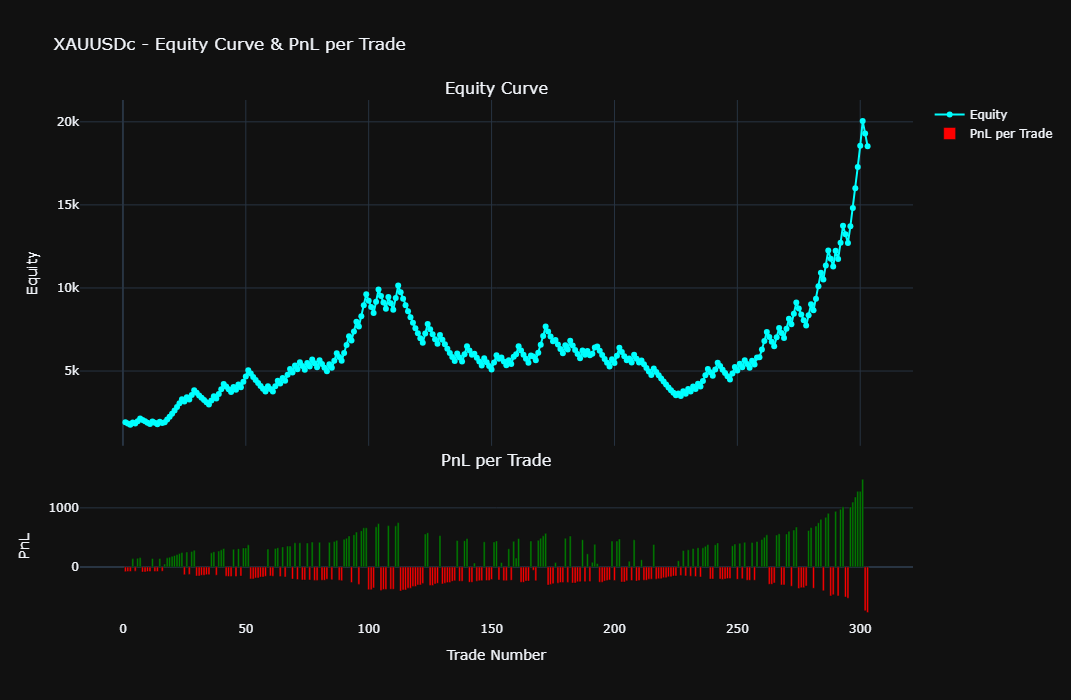

In [22]:
# -----------------------------
# 7. EQUITY CURVE + P&L BARS CHART
# -----------------------------
if trades_df.empty:
    print("No trades executed — cannot plot equity curve.")
else:
    # Sort trades by entry time
    trades_df = trades_df.sort_values('entry_time').reset_index(drop=True)

    # Compute cumulative equity
    trades_df['equity_after_trade'] = 2000 + trades_df['pnl'].cumsum()  # starting equity = 2k
    trades_df['trade_number'] = range(1, len(trades_df)+1)

    # Create subplot: row1 = equity curve, row2 = PnL bars
    fig2 = make_subplots(rows=2, cols=1, shared_xaxes=True, row_heights=[0.7,0.3], vertical_spacing=0.05,
                         subplot_titles=("Equity Curve", "PnL per Trade"))

    # Equity curve
    fig2.add_trace(go.Scatter(
        x=trades_df['trade_number'],
        y=trades_df['equity_after_trade'],
        mode='lines+markers',
        line=dict(color='cyan', width=2),
        name='Equity'
    ), row=1, col=1)

    # PnL bars
    colors = ['green' if pnl > 0 else 'red' for pnl in trades_df['pnl']]
    fig2.add_trace(go.Bar(
        x=trades_df['trade_number'],
        y=trades_df['pnl'],
        marker_color=colors,
        name='PnL per Trade'
    ), row=2, col=1)

    # Layout
    fig2.update_layout(template='plotly_dark', height=700, width=1000,
                       title_text=f"{symbol} - Equity Curve & PnL per Trade")

    fig2.update_xaxes(title_text='Trade Number', row=2, col=1)
    fig2.update_yaxes(title_text='Equity', row=1, col=1)
    fig2.update_yaxes(title_text='PnL', row=2, col=1)

    fig2.show()


In [44]:
import pandas as pd
import numpy as np

if trades_df.empty:
    print("No trades executed — cannot compute performance metrics.")
else:
    # -------------------------
    # Basic PnL metrics
    # -------------------------
    total_net_profit = trades_df['pnl'].sum()
    gross_profit = trades_df[trades_df['pnl'] > 0]['pnl'].sum()
    gross_loss = trades_df[trades_df['pnl'] <= 0]['pnl'].sum()
    profit_factor = abs(gross_profit / gross_loss) if gross_loss != 0 else np.nan
    expected_payoff = trades_df['pnl'].mean()
    
    # -------------------------
    # Equity series
    # -------------------------
    starting_balance = 2000
    # or 2000 depending on your setup
    trades_df['equity'] = starting_balance + trades_df['pnl'].cumsum()
    
    # Peak equity at each point
    trades_df['peak_equity'] = trades_df['equity'].cummax()
    
    # Balance Drawdown Absolute (current balance vs starting)
    balance_drawdown_absolute = starting_balance - trades_df['equity'].iloc[-1]
    balance_drawdown_absolute_pct = balance_drawdown_absolute / starting_balance * 100
    
    # Balance Drawdown Maximal (largest drop from any peak)
    trades_df['BDA'] = trades_df['peak_equity'] - trades_df['equity']
    balance_drawdown_maximal = trades_df['BDA'].max()
    # % version uses peak at that drawdown
    drawdown_peak_idx = trades_df['BDA'].idxmax()
    balance_drawdown_maximal_pct = balance_drawdown_maximal / trades_df['peak_equity'].loc[drawdown_peak_idx] * 100
    
    # Balance Drawdown Relative (current equity vs last peak)
    balance_drawdown_relative = trades_df['peak_equity'].iloc[-1] - trades_df['equity'].iloc[-1]
    balance_drawdown_relative_pct = balance_drawdown_relative / trades_df['peak_equity'].iloc[-1] * 100
    
    # -------------------------
    # Sharpe ratio (simplified)
    # -------------------------
    pnl_std = trades_df['pnl'].std()
    sharpe_ratio = (trades_df['pnl'].mean() / pnl_std * np.sqrt(len(trades_df))) if pnl_std != 0 else np.nan
    
    # -------------------------
    # Trades count & statistics
    # -------------------------
    total_trades = len(trades_df)
    short_trades = trades_df[trades_df['side'] == 'short']
    long_trades = trades_df[trades_df['side'] == 'long']
    short_won_pct = (short_trades['pnl'] > 0).mean() * 100 if len(short_trades) > 0 else np.nan
    long_won_pct = (long_trades['pnl'] > 0).mean() * 100 if len(long_trades) > 0 else np.nan
    profit_trades_pct = (trades_df['pnl'] > 0).mean() * 100
    loss_trades_pct = (trades_df['pnl'] <= 0).mean() * 100
    
    largest_profit_trade = trades_df['pnl'].max()
    largest_loss_trade = trades_df['pnl'].min()
    avg_profit_trade = trades_df[trades_df['pnl'] > 0]['pnl'].mean() if profit_trades_pct > 0 else 0
    avg_loss_trade = trades_df[trades_df['pnl'] <= 0]['pnl'].mean() if loss_trades_pct > 0 else 0
    
    # -------------------------
    # Consecutive wins/losses
    # -------------------------
    pnl_series = trades_df['pnl'].values
    max_consec_win = max_consec_loss = 0
    max_consec_win_count = max_consec_loss_count = 0
    current_win_sum = current_loss_sum = 0
    current_win_count = current_loss_count = 0
    consec_win_sum = []
    consec_loss_sum = []
    
    for pnl in pnl_series:
        if pnl > 0:
            current_win_sum += pnl
            current_win_count += 1
            consec_win_sum.append(current_win_sum)
            max_consec_win = max(max_consec_win, current_win_sum)
            max_consec_win_count = max(max_consec_win_count, current_win_count)
            current_loss_sum = 0
            current_loss_count = 0
        else:
            current_loss_sum += pnl
            current_loss_count += 1
            consec_loss_sum.append(current_loss_sum)
            max_consec_loss = min(max_consec_loss, current_loss_sum)  # most negative
            max_consec_loss_count = max(max_consec_loss_count, current_loss_count)
            current_win_sum = 0
            current_win_count = 0
    
    avg_consec_wins = np.mean([x for x in consec_win_sum if x > 0]) if consec_win_sum else 0
    avg_consec_losses = np.mean([x for x in consec_loss_sum if x < 0]) if consec_loss_sum else 0
    
    # -------------------------
    # Performance summary
    # -------------------------
    perf_summary = pd.DataFrame({
        'Metric': [
            'Total Net Profit', 'Profit Factor', 'Recovery Factor', 'Gross Profit', 'Expected Payoff', 'Sharpe Ratio',
            'Gross Loss', 'Balance Drawdown Absolute', 'Balance Drawdown Absolute (%)',
            'Balance Drawdown Maximal', 'Balance Drawdown Maximal (%)',
            'Balance Drawdown Relative', 'Balance Drawdown Relative (%)',
            'Total Trades', 'Short Trades (won %)', 'Long Trades (won %)', 'Profit Trades (% of total)',
            'Loss Trades (% of total)', 'Largest profit trade', 'Largest loss trade', 'Average profit trade',
            'Average loss trade', 'Maximum consecutive wins ($)', 'Maximum consecutive losses ($)',
            'Maximal consecutive profit (count)', 'Maximal consecutive loss (count)', 'Average consecutive wins',
            'Average consecutive losses'
        ],
        'Value': [
            total_net_profit, profit_factor,
            total_net_profit / balance_drawdown_maximal if balance_drawdown_maximal != 0 else np.nan,
            gross_profit, expected_payoff, sharpe_ratio, gross_loss,
            balance_drawdown_absolute, balance_drawdown_absolute_pct,
            balance_drawdown_maximal, balance_drawdown_maximal_pct,
            balance_drawdown_relative, balance_drawdown_relative_pct,
            total_trades, short_won_pct, long_won_pct, profit_trades_pct, loss_trades_pct,
            largest_profit_trade, largest_loss_trade, avg_profit_trade, avg_loss_trade,
            max_consec_win, max_consec_loss, max_consec_win_count, max_consec_loss_count,
            avg_consec_wins, avg_consec_losses
        ]
    })
    
    print("\nPerformance Summary:")
    print(perf_summary)



Performance Summary:
                                Metric         Value
0                     Total Net Profit  16532.660444
1                        Profit Factor      1.392091
2                      Recovery Factor      2.489085
3                         Gross Profit  58697.979337
4                      Expected Payoff     54.563236
5                         Sharpe Ratio      2.411117
6                           Gross Loss -42165.318894
7            Balance Drawdown Absolute -16532.660444
8        Balance Drawdown Absolute (%)   -826.633022
9             Balance Drawdown Maximal   6642.062384
10        Balance Drawdown Maximal (%)     65.491656
11           Balance Drawdown Relative   1514.688594
12       Balance Drawdown Relative (%)      7.555556
13                        Total Trades    303.000000
14                Short Trades (won %)     46.099291
15                 Long Trades (won %)     40.123457
16          Profit Trades (% of total)     42.904290
17            Loss Trade

Trades: 303, Wins: 130, Losses: 173, Total PnL: 16532.66, Avg R: 0.23


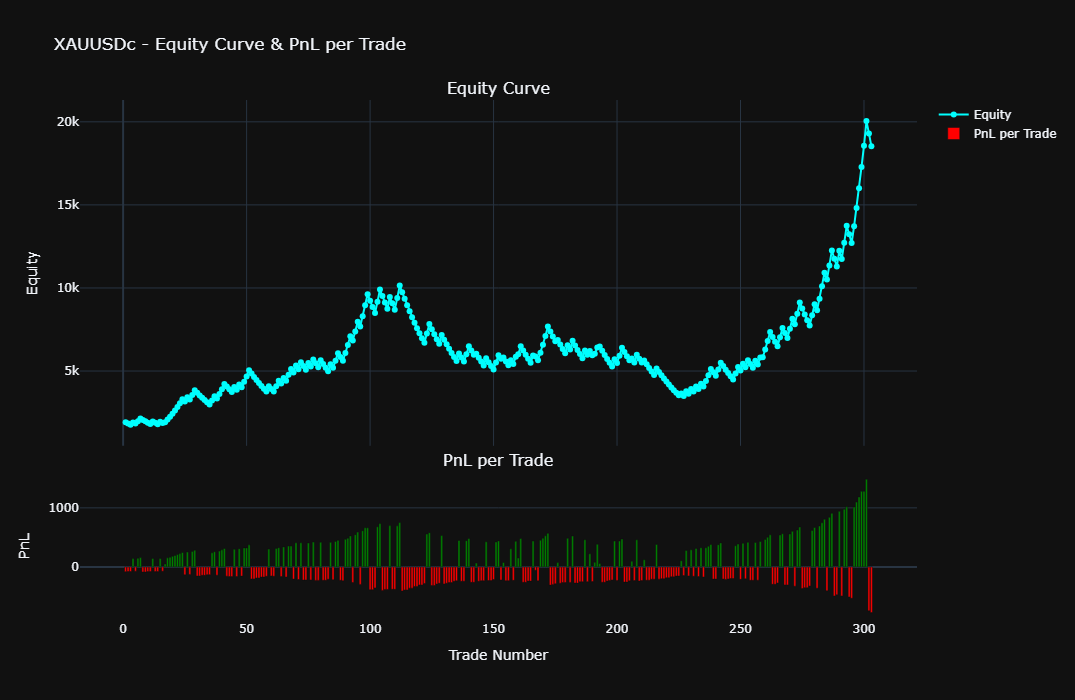


Performance Summary:
                                Metric         Value
0                     Total Net Profit  16532.660444
1                        Profit Factor      1.392091
2                      Recovery Factor      2.489085
3                         Gross Profit  58697.979337
4                      Expected Payoff     54.563236
5                         Sharpe Ratio      2.411117
6                           Gross Loss -42165.318894
7            Balance Drawdown Absolute -16532.660444
8        Balance Drawdown Absolute (%)   -826.633022
9             Balance Drawdown Maximal   6642.062384
10        Balance Drawdown Maximal (%)     65.491656
11           Balance Drawdown Relative   1514.688594
12       Balance Drawdown Relative (%)      7.555556
13                        Total Trades    303.000000
14                Short Trades (won %)     46.099291
15                 Long Trades (won %)     40.123457
16          Profit Trades (% of total)     42.904290
17            Loss Trade

In [53]:
# -----------------------------
# STRATEGY: UTC 12→13 RANGE + REVISIT -> PLACE BOTH STOPS (Buy @High, Sell @Low)
# Backtest simulation (no live order placement)
# -----------------------------

import MetaTrader5 as mt
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import timedelta

# -----------------------------
# 0. CONFIG
# -----------------------------
symbol = "XAUUSDc"           # change to your broker symbol
timeframe = mt.TIMEFRAME_H1  # H1 data
num_candles = 6000           # load enough history to get many days
lookback = 500               # keep existing swing logic (unused here)
risk_multiplier = 2.0        # TP = 2R
risk_per_trade_pct = 0.05    # 5% risk per trade
commission_pct = 0.20        # 20% commission on PnL
spread = 0.2                 # price units
verbose = False              # verbose logging

# -----------------------------
# 1. CONNECT & FETCH
# -----------------------------
if not mt.initialize():
    raise RuntimeError("MT5 initialization failed")

rates = mt.copy_rates_from_pos(symbol, timeframe, 0, num_candles)
df = pd.DataFrame(rates)
df['time'] = pd.to_datetime(df['time'], unit='s')
df.set_index('time', inplace=True)
df.rename(columns={'open':'Open','high':'High','low':'Low','close':'Close','tick_volume':'Volume'}, inplace=True)

# -----------------------------
# 2. CALC DELTA (optional)
# -----------------------------
df['Delta'] = df.apply(lambda r: r['Volume'] if r['Close']>r['Open'] else (-r['Volume'] if r['Close']<r['Open'] else 0), axis=1)

# -----------------------------
# 3. BUILD DAILY UTC 12->13 BOXES
# -----------------------------
df_utc = df.copy()
df_utc.index = df_utc.index.tz_localize('UTC')
df_utc['Date'] = df_utc.index.date

session_boxes = []
for day, day_df in df_utc.groupby('Date'):
    session_df = day_df[(day_df.index.hour == 12)]  # 12:00 - 12:59 UTC
    if len(session_df) == 0:
        continue
    session_high = session_df['High'].max()
    session_low  = session_df['Low'].min()
    session_start = session_df.index[0]
    session_end   = session_df.index[-1]
    mid = (session_high + session_low) / 2.0
    session_boxes.append({
        'date': day,
        'start': session_start,
        'end': session_end,
        'high': session_high,
        'low': session_low,
        'mid': mid
    })

# -----------------------------
# 4. STRATEGY SIMULATION WITH 1% RISK, 20% COMMISSION + SPREAD
# -----------------------------
trades = []  # list of dicts {entry_time, side, entry_price, sl, tp, exit_time, exit_price, pnl, r, position_size}
equity = 2000  # starting capital

for box in session_boxes:
    session_end_naive = box['end'].tz_convert(None) if hasattr(box['end'], 'tzinfo') else box['end']
    try:
        start_loc = df.index.get_loc(session_end_naive)
    except KeyError:
        future_idx = df.index.searchsorted(session_end_naive)
        start_loc = future_idx

    # Monitor candles **only for the same day**
    monitor_slice = df.iloc[start_loc+1:]
    monitor_slice = monitor_slice[monitor_slice.index.date == box['date']]
    if monitor_slice.empty:
        continue

    mid = box['mid']
    box_high = box['high']
    box_low = box['low']

    placed_pending = False
    my_pending = []

    for idx, row in monitor_slice.iterrows():
        # Check for mid revisit to place pending orders
        if not placed_pending:
            if (row['Low'] <= mid <= row['High']):
                placed_pending = True

                # Define buystop at box_high + spread
                buy_entry = box_high + spread
                buy_sl = mid
                buy_r = abs(buy_entry - buy_sl)
                buy_tp = buy_entry + risk_multiplier * buy_r
                buy_position_size = (equity * risk_per_trade_pct) / buy_r

                # Define sellstop at box_low - spread
                sell_entry = box_low - spread
                sell_sl = mid
                sell_r = abs(sell_entry - sell_sl)
                sell_tp = sell_entry - risk_multiplier * sell_r
                sell_position_size = (equity * risk_per_trade_pct) / sell_r

                my_pending = [
                    {'side':'buystop', 'entry':buy_entry, 'sl':buy_sl, 'tp':buy_tp, 'position_size':buy_position_size,
                     'placed_at': idx, 'activated': False},
                    {'side':'sellstop','entry':sell_entry,'sl':sell_sl,'tp':sell_tp,'position_size':sell_position_size,
                     'placed_at': idx,'activated': False}
                ]
                if verbose:
                    print(f"[{box['date']}] Mid revisit at {idx} -> placed pending buy @ {buy_entry} and sell @ {sell_entry}")
                continue
            else:
                continue

        # Check executions for pending orders
        for po in my_pending:
            if po['activated']:
                continue
            if po['side'] == 'buystop' and row['High'] >= po['entry']:
                entry_time = idx
                entry_price = po['entry']
                sl = po['sl']
                tp = po['tp']
                pos_idx = monitor_slice.index.get_loc(idx)
                exit_price = None
                exit_time = None
                pnl = None
                for j in range(pos_idx, len(monitor_slice)):
                    r2 = monitor_slice.iloc[j]
                    if r2['High'] >= tp:
                        exit_price = tp
                        exit_time = monitor_slice.index[j]
                        pnl = (exit_price - entry_price) * po['position_size']
                        break
                    if r2['Low'] <= sl:
                        exit_price = sl
                        exit_time = monitor_slice.index[j]
                        pnl = (exit_price - entry_price) * po['position_size']
                        break
                if exit_price is None:
                    exit_time = monitor_slice.index[-1]
                    exit_price = monitor_slice.iloc[-1]['Close']
                    pnl = (exit_price - entry_price) * po['position_size']

                # Apply commission
                pnl *= (1 - commission_pct)

                trades.append({
                    'box_date': box['date'],
                    'entry_time': entry_time,
                    'side': 'long',
                    'entry_price': entry_price,
                    'sl': sl,
                    'tp': tp,
                    'exit_time': exit_time,
                    'exit_price': exit_price,
                    'pnl': pnl,
                    'r': (exit_price - entry_price) / (entry_price - sl) if (entry_price - sl) != 0 else np.nan,
                    'position_size': po['position_size'],
                    'triggered_by': 'buystop'
                })
                po['activated'] = True
                equity += pnl

            elif po['side'] == 'sellstop' and row['Low'] <= po['entry']:
                entry_time = idx
                entry_price = po['entry']
                sl = po['sl']
                tp = po['tp']
                pos_idx = monitor_slice.index.get_loc(idx)
                exit_price = None
                exit_time = None
                pnl = None
                for j in range(pos_idx, len(monitor_slice)):
                    r2 = monitor_slice.iloc[j]
                    if r2['Low'] <= tp:
                        exit_price = tp
                        exit_time = monitor_slice.index[j]
                        pnl = (entry_price - exit_price) * po['position_size']
                        break
                    if r2['High'] >= sl:
                        exit_price = sl
                        exit_time = monitor_slice.index[j]
                        pnl = (entry_price - exit_price) * po['position_size']
                        break
                if exit_price is None:
                    exit_time = monitor_slice.index[-1]
                    exit_price = monitor_slice.iloc[-1]['Close']
                    pnl = (entry_price - exit_price) * po['position_size']

                # Apply commission
                pnl *= (1 - commission_pct)

                trades.append({
                    'box_date': box['date'],
                    'entry_time': entry_time,
                    'side': 'short',
                    'entry_price': entry_price,
                    'sl': sl,
                    'tp': tp,
                    'exit_time': exit_time,
                    'exit_price': exit_price,
                    'pnl': pnl,
                    'r': (entry_price - exit_price) / (sl - entry_price) if (sl - entry_price) != 0 else np.nan,
                    'position_size': po['position_size'],
                    'triggered_by': 'sellstop'
                })
                po['activated'] = True
                equity += pnl

        if all(po['activated'] for po in my_pending) and len(my_pending) > 0:
            break

    # Reset per-box pending orders
    my_pending = []
    placed_pending = False

# -----------------------------
# 5. REPORT RESULTS
# -----------------------------
trades_df = pd.DataFrame(trades)
if trades_df.empty:
    print("No trades executed in this backtest.")
else:
    total_pnl = trades_df['pnl'].sum()
    wins = trades_df[trades_df['pnl'] > 0].shape[0]
    losses = trades_df[trades_df['pnl'] <= 0].shape[0]
    avg_r = trades_df['r'].mean()
    print(f"Trades: {len(trades_df)}, Wins: {wins}, Losses: {losses}, Total PnL: {total_pnl:.2f}, Avg R: {avg_r:.2f}")

# -----------------------------
# 6. PLOT (candles + boxes + pending/entries/exits)
# -----------------------------
fig = make_subplots(rows=2, cols=1, shared_xaxes=True, row_heights=[0.7,0.25], vertical_spacing=0.03)
fig.add_trace(go.Candlestick(x=df.index, open=df['Open'], high=df['High'], low=df['Low'], close=df['Close'], name='Price'), row=1, col=1)

for b in session_boxes:
    fig.add_shape(type='rect',
                  x0=b['start'].tz_convert(None) if hasattr(b['start'],'tzinfo') else b['start'],
                  x1=b['end'].tz_convert(None) if hasattr(b['end'],'tzinfo') else b['end'],
                  y0=b['low'], y1=b['high'],
                  line=dict(color='cyan', width=1),
                  fillcolor='rgba(0,255,255,0.10)',
                  layer='below')
    fig.add_trace(go.Scatter(
        x=[b['start'].tz_convert(None) if hasattr(b['start'],'tzinfo') else b['start'],
           b['end'].tz_convert(None) if hasattr(b['end'],'tzinfo') else b['end']],
        y=[b['mid'], b['mid']],
        mode='lines',
        line=dict(color='white', width=1, dash='dash'),
        name=f"mid {b['date']}"
    ), row=1, col=1)

if not trades_df.empty:
    fig.add_trace(go.Scatter(x=trades_df['entry_time'], y=trades_df['entry_price'], mode='markers', marker=dict(size=10, symbol='triangle-up'), name='Entry'), row=1, col=1)
    fig.add_trace(go.Scatter(x=trades_df['exit_time'], y=trades_df['exit_price'], mode='markers', marker=dict(size=10, symbol='x'), name='Exit'), row=1, col=1)

colors = ['green' if d>0 else ('red' if d<0 else 'gray') for d in df['Delta']]
fig.add_trace(go.Bar(x=df.index, y=df['Volume'], marker_color=colors, name='Volume'), row=2, col=1)

fig.update_layout(template='plotly_dark', height=900, title=f"{symbol} - UTC12-13 Range Strategy Simulation")
fig.update_yaxes(title_text='Price', row=1, col=1)
fig.update_yaxes(title_text='Volume', row=2, col=1)
fig.update_xaxes(rangeslider_visible=True)
# fig.show()

# -----------------------------
# 7. EQUITY CURVE + P&L BARS CHART
# -----------------------------
if not trades_df.empty:
    trades_df = trades_df.sort_values('entry_time').reset_index(drop=True)
    trades_df['equity_after_trade'] = 2000 + trades_df['pnl'].cumsum()  # starting equity = 2k
    trades_df['trade_number'] = range(1, len(trades_df)+1)

    fig2 = make_subplots(rows=2, cols=1, shared_xaxes=True, row_heights=[0.7,0.3], vertical_spacing=0.05,
                         subplot_titles=("Equity Curve", "PnL per Trade"))

    fig2.add_trace(go.Scatter(x=trades_df['trade_number'], y=trades_df['equity_after_trade'], mode='lines+markers', line=dict(color='cyan', width=2), name='Equity'), row=1, col=1)

    colors = ['green' if pnl > 0 else 'red' for pnl in trades_df['pnl']]
    fig2.add_trace(go.Bar(x=trades_df['trade_number'], y=trades_df['pnl'], marker_color=colors, name='PnL per Trade'), row=2, col=1)

    fig2.update_layout(template='plotly_dark', height=700, width=1000, title_text=f"{symbol} - Equity Curve & PnL per Trade")
    fig2.update_xaxes(title_text='Trade Number', row=2, col=1)
    fig2.update_yaxes(title_text='Equity', row=1, col=1)
    fig2.update_yaxes(title_text='PnL', row=2, col=1)
    fig2.show()

# -----------------------------
# 8. PERFORMANCE METRICS
# -----------------------------
if not trades_df.empty:
    total_net_profit = trades_df['pnl'].sum()
    gross_profit = trades_df[trades_df['pnl'] > 0]['pnl'].sum()
    gross_loss = trades_df[trades_df['pnl'] <= 0]['pnl'].sum()
    profit_factor = abs(gross_profit / gross_loss) if gross_loss != 0 else np.nan
    expected_payoff = trades_df['pnl'].mean()
    starting_balance = 2000
    trades_df['equity'] = starting_balance + trades_df['pnl'].cumsum()
    trades_df['peak_equity'] = trades_df['equity'].cummax()

    balance_drawdown_absolute = starting_balance - trades_df['equity'].iloc[-1]
    balance_drawdown_absolute_pct = balance_drawdown_absolute / starting_balance * 100

    trades_df['BDA'] = trades_df['peak_equity'] - trades_df['equity']
    balance_drawdown_maximal = trades_df['BDA'].max()
    drawdown_peak_idx = trades_df['BDA'].idxmax()
    balance_drawdown_maximal_pct = balance_drawdown_maximal / trades_df['peak_equity'].loc[drawdown_peak_idx] * 100

    balance_drawdown_relative = trades_df['peak_equity'].iloc[-1] - trades_df['equity'].iloc[-1]
    balance_drawdown_relative_pct = balance_drawdown_relative / trades_df['peak_equity'].iloc[-1] * 100

    pnl_std = trades_df['pnl'].std()
    sharpe_ratio = (trades_df['pnl'].mean() / pnl_std * np.sqrt(len(trades_df))) if pnl_std != 0 else np.nan

    total_trades = len(trades_df)
    short_trades = trades_df[trades_df['side'] == 'short']
    long_trades = trades_df[trades_df['side'] == 'long']
    short_won_pct = (short_trades['pnl'] > 0).mean() * 100 if len(short_trades) > 0 else np.nan
    long_won_pct = (long_trades['pnl'] > 0).mean() * 100 if len(long_trades) > 0 else np.nan
    profit_trades_pct = (trades_df['pnl'] > 0).mean() * 100
    loss_trades_pct = (trades_df['pnl'] <= 0).mean() * 100

    largest_profit_trade = trades_df['pnl'].max()
    largest_loss_trade = trades_df['pnl'].min()
    avg_profit_trade = trades_df[trades_df['pnl'] > 0]['pnl'].mean() if profit_trades_pct > 0 else 0
    avg_loss_trade = trades_df[trades_df['pnl'] <= 0]['pnl'].mean() if loss_trades_pct > 0 else 0

    # Consecutive wins/losses
    pnl_series = trades_df['pnl'].values
    max_consec_win = max_consec_loss = 0
    max_consec_win_count = max_consec_loss_count = 0
    current_win_sum = current_loss_sum = 0
    current_win_count = current_loss_count = 0
    consec_win_sum = []
    consec_loss_sum = []

    for pnl in pnl_series:
        if pnl > 0:
            current_win_sum += pnl
            current_win_count += 1
            consec_win_sum.append(current_win_sum)
            max_consec_win = max(max_consec_win, current_win_sum)
            max_consec_win_count = max(max_consec_win_count, current_win_count)
            current_loss_sum = 0
            current_loss_count = 0
        else:
            current_loss_sum += pnl
            current_loss_count += 1
            consec_loss_sum.append(current_loss_sum)
            max_consec_loss = min(max_consec_loss, current_loss_sum)
            max_consec_loss_count = max(max_consec_loss_count, current_loss_count)
            current_win_sum = 0
            current_win_count = 0

    avg_consec_wins = np.mean([x for x in consec_win_sum if x > 0]) if consec_win_sum else 0
    avg_consec_losses = np.mean([x for x in consec_loss_sum if x < 0]) if consec_loss_sum else 0

    perf_summary = pd.DataFrame({
        'Metric': [
            'Total Net Profit', 'Profit Factor', 'Recovery Factor', 'Gross Profit', 'Expected Payoff', 'Sharpe Ratio',
            'Gross Loss', 'Balance Drawdown Absolute', 'Balance Drawdown Absolute (%)',
            'Balance Drawdown Maximal', 'Balance Drawdown Maximal (%)',
            'Balance Drawdown Relative', 'Balance Drawdown Relative (%)',
            'Total Trades', 'Short Trades (won %)', 'Long Trades (won %)', 'Profit Trades (% of total)',
            'Loss Trades (% of total)', 'Largest profit trade', 'Largest loss trade', 'Average profit trade',
            'Average loss trade', 'Maximum consecutive wins ($)', 'Maximum consecutive losses ($)',
            'Maximal consecutive profit (count)', 'Maximal consecutive loss (count)', 'Average consecutive wins',
            'Average consecutive losses'
        ],
        'Value': [
            total_net_profit, profit_factor,
            total_net_profit / balance_drawdown_maximal if balance_drawdown_maximal != 0 else np.nan,
            gross_profit, expected_payoff, sharpe_ratio, gross_loss,
            balance_drawdown_absolute, balance_drawdown_absolute_pct,
            balance_drawdown_maximal, balance_drawdown_maximal_pct,
            balance_drawdown_relative, balance_drawdown_relative_pct,
            total_trades, short_won_pct, long_won_pct, profit_trades_pct, loss_trades_pct,
            largest_profit_trade, largest_loss_trade, avg_profit_trade, avg_loss_trade,
            max_consec_win, max_consec_loss, max_consec_win_count, max_consec_loss_count,
            avg_consec_wins, avg_consec_losses
        ]
    })

    print("\nPerformance Summary:")
    print(perf_summary)


     trade_number          entry_time   side     entry         sl        tp  \
0               1 2024-11-19 14:00:00  short  2628.519  2634.0415  2617.474   
1               2 2024-11-21 14:00:00  short  2662.697  2667.3565  2653.378   
2               3 2024-11-21 17:00:00   long  2672.016  2667.3565  2681.335   
3               4 2024-11-22 14:00:00  short  2696.796  2701.0070  2688.374   
4               5 2024-11-22 16:00:00   long  2705.218  2701.0070  2713.640   
..            ...                 ...    ...       ...        ...       ...   
298           299 2025-11-19 14:00:00   long  4120.210  4116.0970  4128.436   
299           300 2025-11-19 14:00:00  short  4111.984  4116.0970  4103.758   
300           301 2025-11-20 14:00:00   long  4082.284  4071.0840  4104.684   
301           302 2025-11-20 16:00:00  short  4059.884  4071.0840  4037.484   
302           303 2025-11-24 14:00:00   long  4084.308  4074.8715  4103.181   

              exit_time       exit          pnl    

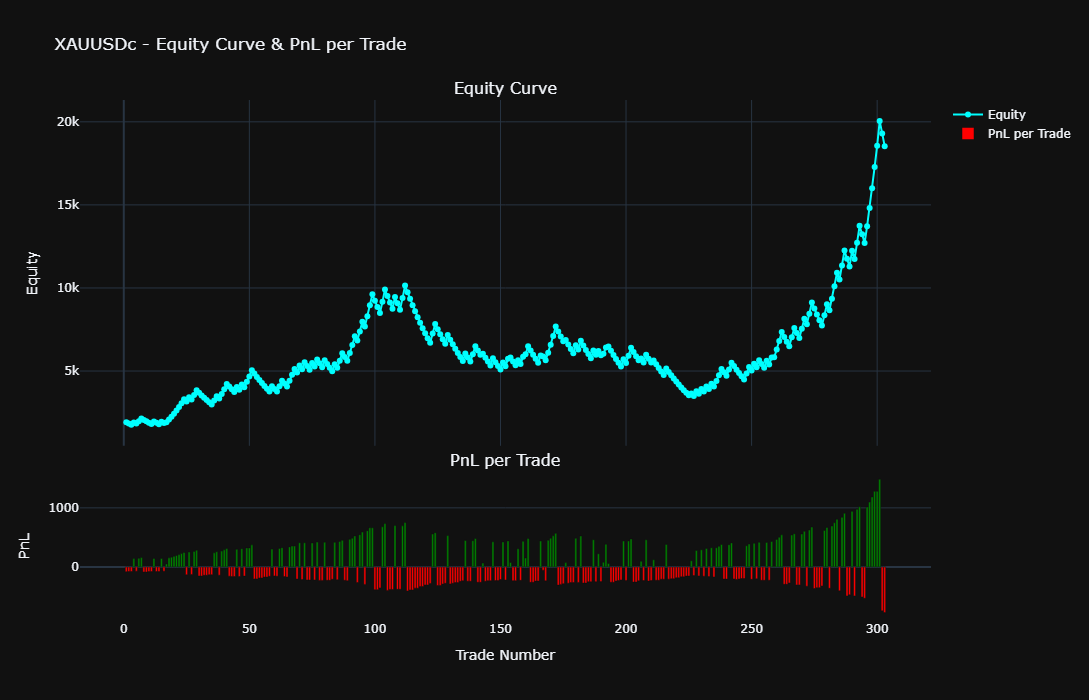


Performance Summary:
                                Metric         Value
0                     Total Net Profit  16532.660444
1                        Profit Factor      1.392091
2                      Recovery Factor      2.489085
3                         Gross Profit  58697.979337
4                      Expected Payoff     54.563236
5                         Sharpe Ratio      2.411117
6                           Gross Loss -42165.318894
7            Balance Drawdown Absolute -16532.660444
8        Balance Drawdown Absolute (%)   -826.633022
9             Balance Drawdown Maximal   6642.062384
10        Balance Drawdown Maximal (%)     65.491656
11           Balance Drawdown Relative   1514.688594
12       Balance Drawdown Relative (%)      7.555556
13                        Total Trades    303.000000
14                Short Trades (won %)     46.099291
15                 Long Trades (won %)     40.123457
16          Profit Trades (% of total)     42.904290
17            Loss Trade

In [52]:
# -----------------------------
# STRATEGY: UTC 12→13 RANGE + REVISIT -> PLACE BOTH STOPS (Buy @High, Sell @Low)
# Backtest simulation (no live order placement)
# -----------------------------

import MetaTrader5 as mt
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import timedelta

# -----------------------------
# 0. CONFIG
# -----------------------------
symbol = "XAUUSDc"
timeframe = mt.TIMEFRAME_H1
num_candles = 6000
risk_multiplier = 2.0
risk_per_trade_pct = 0.05
commission_pct = 0.20
spread = 0.2
equity_start = 2000
verbose = False

# -----------------------------
# 1. CONNECT & FETCH
# -----------------------------
if not mt.initialize():
    raise RuntimeError("MT5 initialization failed")

rates = mt.copy_rates_from_pos(symbol, timeframe, 0, num_candles)
df = pd.DataFrame(rates)
df['time'] = pd.to_datetime(df['time'], unit='s')
df.set_index('time', inplace=True)
df.rename(columns={'open':'Open','high':'High','low':'Low','close':'Close','tick_volume':'Volume'}, inplace=True)

# -----------------------------
# 2. CALC DELTA
# -----------------------------
df['Delta'] = df.apply(lambda r: r['Volume'] if r['Close']>r['Open'] else (-r['Volume'] if r['Close']<r['Open'] else 0), axis=1)

# -----------------------------
# 3. BUILD DAILY UTC 12->13 BOXES
# -----------------------------
df_utc = df.copy()
df_utc.index = df_utc.index.tz_localize('UTC')
df_utc['Date'] = df_utc.index.date

session_boxes = []
for day, day_df in df_utc.groupby('Date'):
    session_df = day_df[(day_df.index.hour == 12)]
    if len(session_df) == 0:
        continue
    session_high = session_df['High'].max()
    session_low  = session_df['Low'].min()
    session_start = session_df.index[0]
    session_end   = session_df.index[-1]
    mid = (session_high + session_low) / 2.0
    session_boxes.append({
        'date': day,
        'start': session_start,
        'end': session_end,
        'high': session_high,
        'low': session_low,
        'mid': mid
    })

# -----------------------------
# 4. STRATEGY SIMULATION
# -----------------------------
trades = []
equity = equity_start

for box in session_boxes:
    session_end_naive = box['end'].tz_convert(None) if hasattr(box['end'], 'tzinfo') else box['end']
    try:
        start_loc = df.index.get_loc(session_end_naive)
    except KeyError:
        start_loc = df.index.searchsorted(session_end_naive)

    monitor_slice = df.iloc[start_loc+1:]
    monitor_slice = monitor_slice[monitor_slice.index.date == box['date']]
    if monitor_slice.empty:
        continue

    mid = box['mid']
    box_high = box['high']
    box_low = box['low']

    placed_pending = False
    my_pending = []

    for idx, row in monitor_slice.iterrows():
        if not placed_pending and (row['Low'] <= mid <= row['High']):
            placed_pending = True
            buy_entry = box_high + spread
            buy_sl = mid
            buy_r = abs(buy_entry - buy_sl)
            buy_tp = buy_entry + risk_multiplier * buy_r
            buy_size = (equity * risk_per_trade_pct) / buy_r

            sell_entry = box_low - spread
            sell_sl = mid
            sell_r = abs(sell_entry - sell_sl)
            sell_tp = sell_entry - risk_multiplier * sell_r
            sell_size = (equity * risk_per_trade_pct) / sell_r

            my_pending = [
                {'side':'buystop', 'entry':buy_entry, 'sl':buy_sl, 'tp':buy_tp, 'size':buy_size, 'activated':False},
                {'side':'sellstop','entry':sell_entry,'sl':sell_sl,'tp':sell_tp,'size':sell_size, 'activated':False}
            ]
            continue

        # Execute pending orders
        for po in my_pending:
            if po['activated']:
                continue
            pos_idx = monitor_slice.index.get_loc(idx)
            exit_price = None
            exit_time = None
            pnl = None

            if po['side'] == 'buystop' and row['High'] >= po['entry']:
                entry_price = po['entry']
                sl = po['sl']
                tp = po['tp']
                for j in range(pos_idx, len(monitor_slice)):
                    r2 = monitor_slice.iloc[j]
                    if r2['High'] >= tp:
                        exit_price = tp
                        exit_time = monitor_slice.index[j]
                        pnl = (exit_price - entry_price) * po['size']
                        break
                    if r2['Low'] <= sl:
                        exit_price = sl
                        exit_time = monitor_slice.index[j]
                        pnl = (exit_price - entry_price) * po['size']
                        break
                if exit_price is None:
                    exit_time = monitor_slice.index[-1]
                    exit_price = monitor_slice.iloc[-1]['Close']
                    pnl = (exit_price - entry_price) * po['size']

                pnl *= (1 - commission_pct)
                trades.append({'entry_time':idx,'side':'long','entry':entry_price,'sl':sl,'tp':tp,'exit_time':exit_time,'exit':exit_price,'pnl':pnl})
                po['activated'] = True
                equity += pnl

            elif po['side'] == 'sellstop' and row['Low'] <= po['entry']:
                entry_price = po['entry']
                sl = po['sl']
                tp = po['tp']
                for j in range(pos_idx, len(monitor_slice)):
                    r2 = monitor_slice.iloc[j]
                    if r2['Low'] <= tp:
                        exit_price = tp
                        exit_time = monitor_slice.index[j]
                        pnl = (entry_price - exit_price) * po['size']
                        break
                    if r2['High'] >= sl:
                        exit_price = sl
                        exit_time = monitor_slice.index[j]
                        pnl = (entry_price - exit_price) * po['size']
                        break
                if exit_price is None:
                    exit_time = monitor_slice.index[-1]
                    exit_price = monitor_slice.iloc[-1]['Close']
                    pnl = (entry_price - exit_price) * po['size']

                pnl *= (1 - commission_pct)
                trades.append({'entry_time':idx,'side':'short','entry':entry_price,'sl':sl,'tp':tp,'exit_time':exit_time,'exit':exit_price,'pnl':pnl})
                po['activated'] = True
                equity += pnl

        if all(po['activated'] for po in my_pending) and len(my_pending) > 0:
            break

    my_pending = []
    placed_pending = False

# -----------------------------
# 5. REPORT RESULTS
# -----------------------------
trades_df = pd.DataFrame(trades)
if trades_df.empty:
    print("No trades executed in this backtest.")
else:
    trades_df['cum_equity'] = equity_start + trades_df['pnl'].cumsum()
    trades_df['trade_number'] = range(1, len(trades_df)+1)
    print(trades_df[['trade_number','entry_time','side','entry','sl','tp','exit_time','exit','pnl','cum_equity']])

# -----------------------------
# 6. EQUITY CURVE + P&L BARS CHART
# -----------------------------
if not trades_df.empty:
    fig2 = make_subplots(rows=2, cols=1, shared_xaxes=True, row_heights=[0.7,0.3], vertical_spacing=0.05,
                         subplot_titles=("Equity Curve", "PnL per Trade"))

    fig2.add_trace(go.Scatter(x=trades_df['trade_number'], y=trades_df['cum_equity'], mode='lines+markers', line=dict(color='cyan', width=2), name='Equity'), row=1, col=1)
    colors = ['green' if pnl > 0 else 'red' for pnl in trades_df['pnl']]
    fig2.add_trace(go.Bar(x=trades_df['trade_number'], y=trades_df['pnl'], marker_color=colors, name='PnL per Trade'), row=2, col=1)
    fig2.update_layout(template='plotly_dark', height=700, width=1000, title_text=f"{symbol} - Equity Curve & PnL per Trade")
    fig2.update_xaxes(title_text='Trade Number', row=2, col=1)
    fig2.update_yaxes(title_text='Equity', row=1, col=1)
    fig2.update_yaxes(title_text='PnL', row=2, col=1)
    fig2.show()

# -----------------------------
# 7. PERFORMANCE METRICS
# -----------------------------
if not trades_df.empty:
    total_net_profit = trades_df['pnl'].sum()
    gross_profit = trades_df[trades_df['pnl'] > 0]['pnl'].sum()
    gross_loss = trades_df[trades_df['pnl'] <= 0]['pnl'].sum()
    profit_factor = abs(gross_profit / gross_loss) if gross_loss != 0 else np.nan
    expected_payoff = trades_df['pnl'].mean()
    starting_balance = equity_start
    trades_df['equity'] = starting_balance + trades_df['pnl'].cumsum()
    trades_df['peak_equity'] = trades_df['equity'].cummax()
    trades_df['BDA'] = trades_df['peak_equity'] - trades_df['equity']

    balance_drawdown_absolute = starting_balance - trades_df['equity'].iloc[-1]
    balance_drawdown_absolute_pct = balance_drawdown_absolute / starting_balance * 100

    balance_drawdown_maximal = trades_df['BDA'].max()
    drawdown_peak_idx = trades_df['BDA'].idxmax()
    balance_drawdown_maximal_pct = balance_drawdown_maximal / trades_df['peak_equity'].loc[drawdown_peak_idx] * 100

    balance_drawdown_relative = trades_df['peak_equity'].iloc[-1] - trades_df['equity'].iloc[-1]
    balance_drawdown_relative_pct = balance_drawdown_relative / trades_df['peak_equity'].iloc[-1] * 100

    pnl_std = trades_df['pnl'].std()
    sharpe_ratio = (trades_df['pnl'].mean() / pnl_std * np.sqrt(len(trades_df))) if pnl_std != 0 else np.nan

    total_trades = len(trades_df)
    short_trades = trades_df[trades_df['side']=='short']
    long_trades = trades_df[trades_df['side']=='long']
    short_won_pct = (short_trades['pnl']>0).mean()*100 if len(short_trades)>0 else np.nan
    long_won_pct = (long_trades['pnl']>0).mean()*100 if len(long_trades)>0 else np.nan
    profit_trades_pct = (trades_df['pnl']>0).mean()*100
    loss_trades_pct = (trades_df['pnl']<=0).mean()*100

    largest_profit_trade = trades_df['pnl'].max()
    largest_loss_trade = trades_df['pnl'].min()
    avg_profit_trade = trades_df[trades_df['pnl']>0]['pnl'].mean() if profit_trades_pct>0 else 0
    avg_loss_trade = trades_df[trades_df['pnl']<=0]['pnl'].mean() if loss_trades_pct>0 else 0

    # Consecutive wins/losses
    pnl_series = trades_df['pnl'].values
    max_consec_win = max_consec_loss = 0
    max_consec_win_count = max_consec_loss_count = 0
    current_win_sum = current_loss_sum = 0
    current_win_count = current_loss_count = 0
    consec_win_sum = []
    consec_loss_sum = []

    for pnl in pnl_series:
        if pnl>0:
            current_win_sum += pnl
            current_win_count += 1
            consec_win_sum.append(current_win_sum)
            max_consec_win = max(max_consec_win, current_win_sum)
            max_consec_win_count = max(max_consec_win_count, current_win_count)
            current_loss_sum = 0
            current_loss_count = 0
        else:
            current_loss_sum += pnl
            current_loss_count += 1
            consec_loss_sum.append(current_loss_sum)
            max_consec_loss = min(max_consec_loss, current_loss_sum)
            max_consec_loss_count = max(max_consec_loss_count, current_loss_count)
            current_win_sum = 0
            current_win_count = 0

    avg_consec_wins = np.mean([x for x in consec_win_sum if x>0]) if consec_win_sum else 0
    avg_consec_losses = np.mean([x for x in consec_loss_sum if x<0]) if consec_loss_sum else 0

    perf_summary = pd.DataFrame({
        'Metric': [
            'Total Net Profit', 'Profit Factor', 'Recovery Factor', 'Gross Profit', 'Expected Payoff', 'Sharpe Ratio',
            'Gross Loss', 'Balance Drawdown Absolute', 'Balance Drawdown Absolute (%)',
            'Balance Drawdown Maximal', 'Balance Drawdown Maximal (%)',
            'Balance Drawdown Relative', 'Balance Drawdown Relative (%)',
            'Total Trades', 'Short Trades (won %)', 'Long Trades (won %)', 'Profit Trades (% of total)',
            'Loss Trades (% of total)', 'Largest profit trade', 'Largest loss trade', 'Average profit trade',
            'Average loss trade', 'Maximum consecutive wins ($)', 'Maximum consecutive losses ($)',
            'Maximal consecutive profit (count)', 'Maximal consecutive loss (count)', 'Average consecutive wins',
            'Average consecutive losses'
        ],
        'Value': [
            total_net_profit, profit_factor,
            total_net_profit / balance_drawdown_maximal if balance_drawdown_maximal!=0 else np.nan,
            gross_profit, expected_payoff, sharpe_ratio, gross_loss,
            balance_drawdown_absolute, balance_drawdown_absolute_pct,
            balance_drawdown_maximal, balance_drawdown_maximal_pct,
            balance_drawdown_relative, balance_drawdown_relative_pct,
            total_trades, short_won_pct, long_won_pct, profit_trades_pct, loss_trades_pct,
            largest_profit_trade, largest_loss_trade, avg_profit_trade, avg_loss_trade,
            max_consec_win, max_consec_loss, max_consec_win_count, max_consec_loss_count,
            avg_consec_wins, avg_consec_losses
        ]
    })

    print("\nPerformance Summary:")
    print(perf_summary)
